In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [130]:
url = "https://raw.githubusercontent.com/NeelDhebar/PortugueseRetailSalesPred/main/portuguese_retail_sales.csv"
data = pd.read_csv(url)
#renaming the columns from Portuguese
data = data.rename(columns={
    'data': 'date',
    'venda': 'sales',
    'estoque': 'stock',
    'preco': 'price'
})
data.head()

,date,sales,stock,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [131]:
data['date'] = pd.to_datetime(data['date'])
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dayofweek'] = data['date'].dt.dayofweek
data['is_weekend'] = data['dayofweek'].isin([5, 6]).astype(int)

In [132]:
data['sales_lag_1'] = data['sales'].shift(1)
data['sales_lag_7'] = data['sales'].shift(7)

In [133]:
data['sales_rolling_7'] = data['sales'].shift(1).rolling(window=7).mean()

In [134]:
data['price_change'] = data['price'].pct_change()
data['revenue'] = data['price'] * data['sales']

In [135]:
data["stock_to_sales_ratio"] = np.where(
    data["sales_lag_7"] != 0,
    data["stock"] / data["sales_lag_7"],
    np.nan
)

In [136]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

In [137]:
data.isnull().sum()

,0
date,0
sales,0
stock,0
price,0
day,0
month,0
year,0
dayofweek,0
is_weekend,0
sales_lag_1,0


<class 'pandas.core.frame.DataFrame'>
Index: 812 entries, 8 to 936
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  812 non-null    datetime64[ns]
 1   sales                 812 non-null    int64         
 2   stock                 812 non-null    int64         
 3   price                 812 non-null    float64       
 4   day                   812 non-null    int32         
 5   month                 812 non-null    int32         
 6   year                  812 non-null    int32         
 7   dayofweek             812 non-null    int32         
 8   is_weekend            812 non-null    int64         
 9   sales_lag_1           812 non-null    float64       
 10  sales_lag_7           812 non-null    float64       
 11  sales_rolling_7       812 non-null    float64       
 12  price_change          812 non-null    float64       
 13  revenue               812

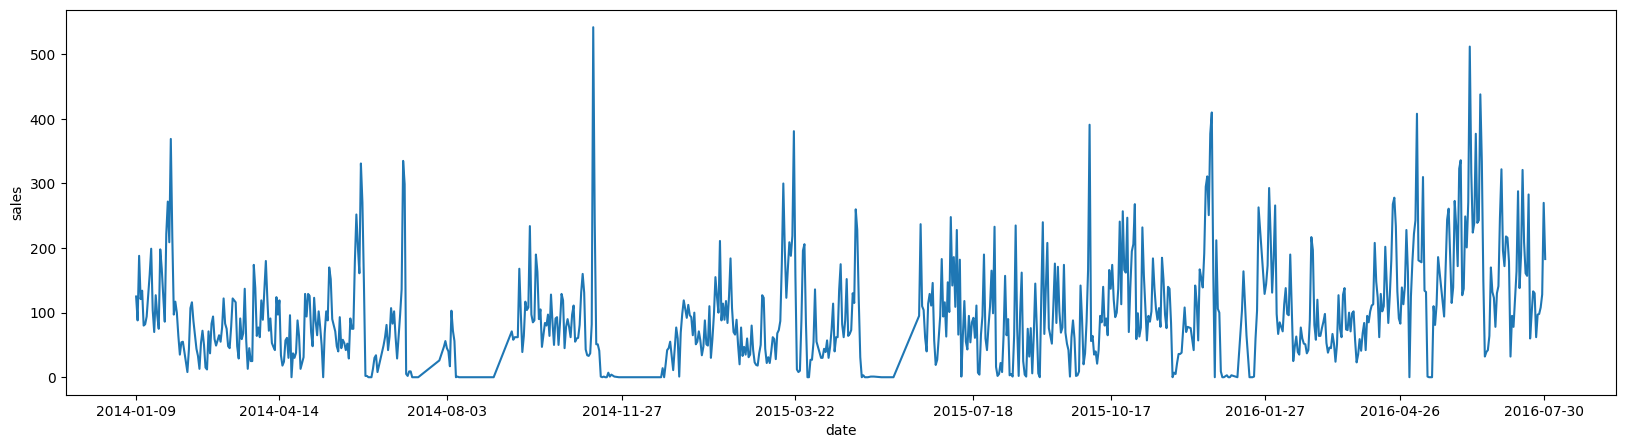

In [138]:
print(data.info())
print(data.describe())
plt.figure(figsize=(20,5))
sns.lineplot(x="date", y="sales", data=data)
plt.xticks(data['date'][::90])
plt.show()

In [139]:
X = data[['dayofweek', 'stock', 'price', 'is_weekend', 'sales_lag_7', 'sales_rolling_7', 'price_change', 'stock_to_sales_ratio', 'sales_lag_1', 'revenue']]
y = data['sales']

In [140]:
num_cols = ['revenue', 'sales', 'stock', 'price', 'sales_lag_7', 'sales_rolling_7', 'price_change', 'sales_lag_1']
for col in num_cols:
    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    data[col] = np.clip(data[col], lower, upper)

In [141]:
train_size = int(len(data) * 0.8)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [142]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [143]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 3406.067665269955
R² Score: 0.6029679096769884


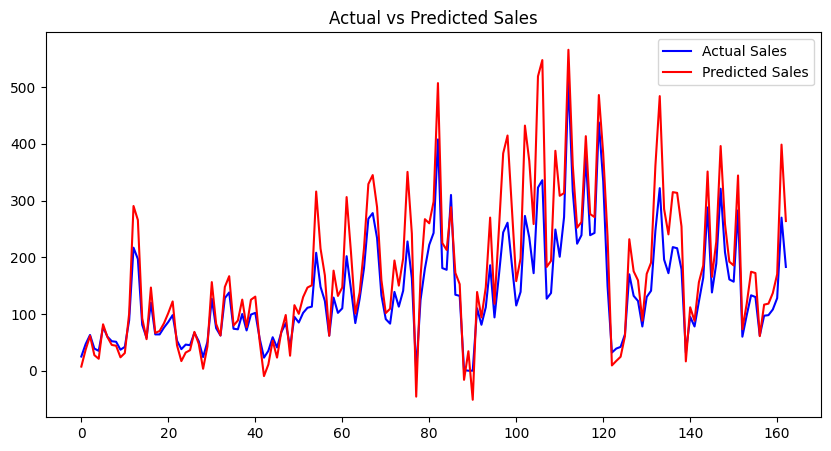

In [144]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(y_pred, label='Predicted Sales', color='red')
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()

In [145]:
print(X.describe())
print(X.dtypes)


        dayofweek        stock       price  is_weekend  sales_lag_7  \
count  812.000000   812.000000  812.000000  812.000000   812.000000   
mean     3.022167  1693.719212    1.623337    0.289409   102.512315   
std      1.993702  1360.149942    0.546770    0.453768    78.381539   
min      0.000000     0.000000    0.000000    0.000000     1.000000   
25%      1.000000   889.000000    1.290000    0.000000    50.750000   
50%      3.000000  1420.000000    1.390000    0.000000    85.500000   
75%      5.000000  1985.250000    1.990000    1.000000   135.000000   
max      6.000000  7228.000000    2.980000    1.000000   542.000000   

       sales_rolling_7  price_change  stock_to_sales_ratio  sales_lag_1  \
count       812.000000    812.000000            812.000000   812.000000   
mean         98.988388     -0.003012             55.996561    97.054187   
std          54.870584      0.137821            195.605350    80.096609   
min           0.142857     -1.000000              0.000000  

In [146]:
data[['stock', 'price', 'sales_lag_7', 'sales_rolling_7', 'price_change', 'stock_to_sales_ratio']].corr()


,stock,price,sales_lag_7,sales_rolling_7,price_change,stock_to_sales_ratio
stock,1.000000,-0.070977,-0.029987,-0.001956,-0.003840,0.138103
price,-0.070977,1.000000,0.116398,0.118111,0.180820,-0.057350
sales_lag_7,-0.029987,0.116398,1.000000,0.612224,0.012658,-0.270547
sales_rolling_7,-0.001956,0.118111,0.612224,1.000000,0.073860,-0.159359
price_change,-0.003840,0.180820,0.012658,0.073860,1.000000,-0.003119
stock_to_sales_ratio,0.138103,-0.057350,-0.270547,-0.159359,-0.003119,1.000000


In [147]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

X_train_poly, X_test_poly = X_poly[:train_size], X_poly[train_size:]

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
pred_poly = model_poly.predict(X_test_poly)

print("MSE:", mean_squared_error(y_test, pred_poly))
print("R²:", r2_score(y_test, pred_poly))

MSE: 183.74862991131923
R²: 0.9785811352570711


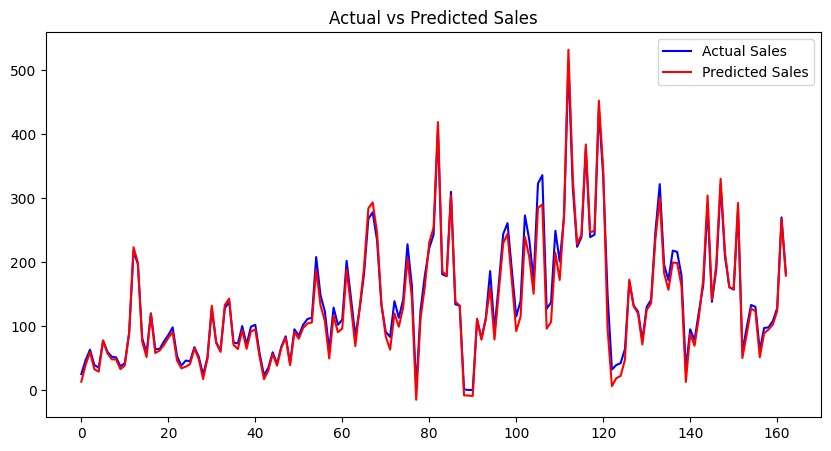

In [148]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(pred_poly, label='Predicted Sales', color='red')
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()

In [149]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly, y_train)
ridge_pred = ridge.predict(X_test_poly)
print("MSE:", mean_squared_error(y_test, ridge_pred))
print("R²:", r2_score(y_test, ridge_pred))

MSE: 173.49861222417528
R²: 0.9797759400431505


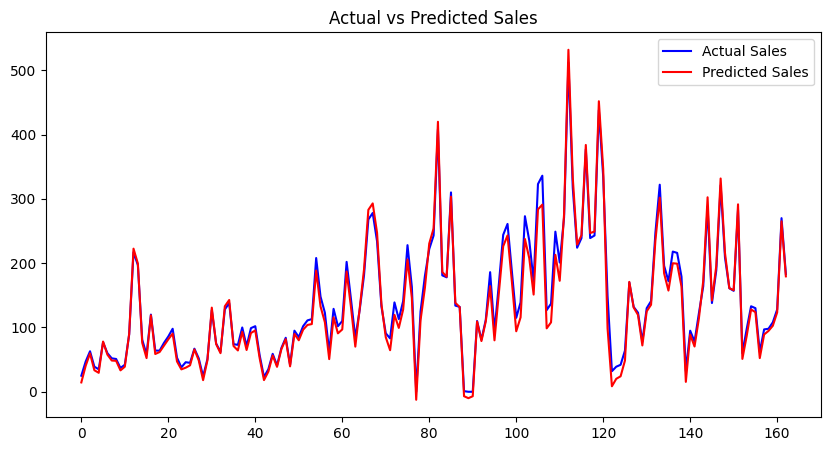

In [150]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(ridge_pred, label='Predicted Sales', color='red')
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()

In [151]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, rf_pred))
print("R²:", r2_score(y_test, rf_pred))

MSE: 1009.318782822086
R²: 0.8823476261989147


In [152]:
train_pred = model_poly.predict(X_train_poly)
test_pred  = model_poly.predict(X_test_poly)

print("Train MSE:", mean_squared_error(y_train, train_pred))
print("Train R2: ", r2_score(y_train, train_pred))
print("Test  MSE:", mean_squared_error(y_test, test_pred))
print("Test  R2: ", r2_score(y_test, test_pred))

Train MSE: 14.600653217841954
Train R2:  0.9972384332218128
Test  MSE: 183.74862991131923
Test  R2:  0.9785811352570711


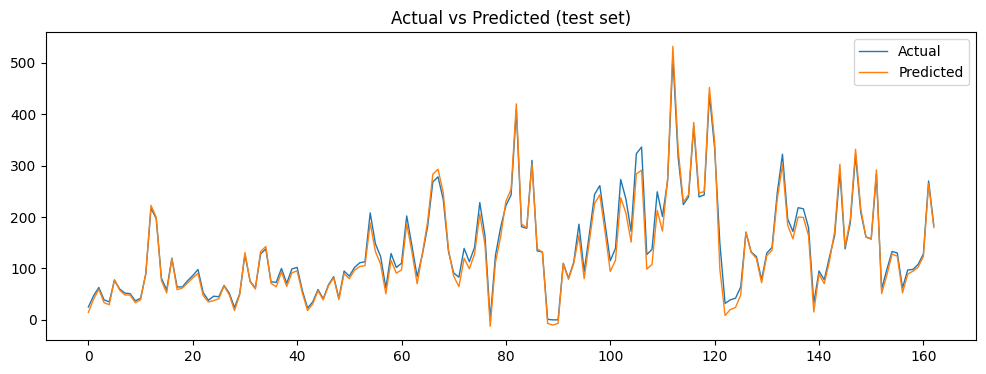

In [153]:
y_test = y_test.reset_index(drop=True)
preds = pd.Series(ridge_pred).reset_index(drop=True)   # or model_pred

plt.figure(figsize=(12,4))
plt.plot(y_test, label='Actual', linewidth=1)
plt.plot(preds, label='Predicted', linewidth=1)
plt.legend()
plt.title('Actual vs Predicted (test set)')
plt.show()